# Import SQL Data into Python

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
# 1. Database Connection Details 
config = {
    'user': 'root',
    'password': 'Oshu@9207',
    'host': 'localhost', 
    'database': 'student_db'
}

In [3]:
# 2. SQL Query to Join Data

sql_query = """
SELECT
    S.student_id,
    S.first_name,
    S.last_name,
    (A.classes_attended * 100.0 / A.total_classes) AS Attendance_Percent,
    AVG(G.marks) AS Average_Marks
FROM
    Students AS S
JOIN
    Attendance AS A ON S.student_id = A.student_id
JOIN
    Grades AS G ON S.student_id = G.student_id
GROUP BY
    S.student_id, S.first_name, S.last_name, A.classes_attended, A.total_classes;
"""

In [4]:

# 3. Connecting and Executing
try:
    conn = mysql.connector.connect(**config)
    
    # Read the SQL query result into a Pandas DataFrame
    df = pd.read_sql(sql_query, conn)
    
    conn.close()
    print("Data imported successfully!")

except mysql.connector.Error as err:
    print(f"Error: {err}")
    df = pd.DataFrame() # Create empty DataFrame if connection fails

# Displaying the first few rows
print(df.head())

Data imported successfully!
   student_id first_name last_name  Attendance_Percent  Average_Marks
0         101      Alice     Smith            95.00000           90.0
1         102        Bob   Johnson            50.00000           47.5
2         103    Charlie     Brown            93.75000           72.5
3         104      Diana    Prince            88.00000           92.5
4         105       Evan    Taylor            91.11111           82.5


C:\Users\Osheen kumar\AppData\Local\Temp\ipykernel_7040\2525997575.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


# Preprocess and clean the data.

In [5]:
# Defining a passing criteria (e.g., marks > 40 and attendance > 75%)
PASS_MARK_THRESHOLD = 50
PASS_ATTENDANCE_THRESHOLD = 70

# Creating the 'PassFail' column (target variable for prediction)
df['PassFail'] = ((df['Average_Marks'] > PASS_MARK_THRESHOLD) & 
                   (df['Attendance_Percent'] > PASS_ATTENDANCE_THRESHOLD)).astype(int)

print(df[['Average_Marks', 'Attendance_Percent', 'PassFail']])

   Average_Marks  Attendance_Percent  PassFail
0           90.0            95.00000         1
1           47.5            50.00000         0
2           72.5            93.75000         1
3           92.5            88.00000         1
4           82.5            91.11111         1
5           89.5            72.22222         1
6           41.5            37.50000         0
7           56.5            50.00000         0
8           68.5            70.00000         0
9           41.0            25.00000         0


In [6]:
# Splitting data into training and testing set
X = df[['Attendance_Percent', 'Average_Marks']]
y = df['PassFail']
# Split the data: 80% for training, 20% for testing (adjust if needed, but 80/20 is standard)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=84)

print(f"\nTraining set size: {len(X_train)} records")
print(f"Testing set size: {len(X_test)} records")


Training set size: 8 records
Testing set size: 2 records


# Machine Learning Model (Prediction)

In [7]:
#Apply Logistic Regression# Initialize and Train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=84)
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test)


In [8]:
# Evaluate Model Accuracy
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nLogistic Regression Model Accuracy: {accuracy:.2f}")

# Display the Confusion Matrix (shows how many predictions were correct/incorrect)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (Test Set):")
print(conf_matrix)
# Interpretation:
# conf_matrix[0, 0] = True Negatives (Correctly predicted Fail)
# conf_matrix[0, 1] = False Positives (Predicted Pass, but actually Failed)
# conf_matrix[1, 0] = False Negatives (Predicted Fail, but actually Passed)
# conf_matrix[1, 1] = True Positives (Correctly predicted Pass)


Logistic Regression Model Accuracy: 1.00

Confusion Matrix (Test Set):
[[1 0]
 [0 1]]


# Visualization and Insights

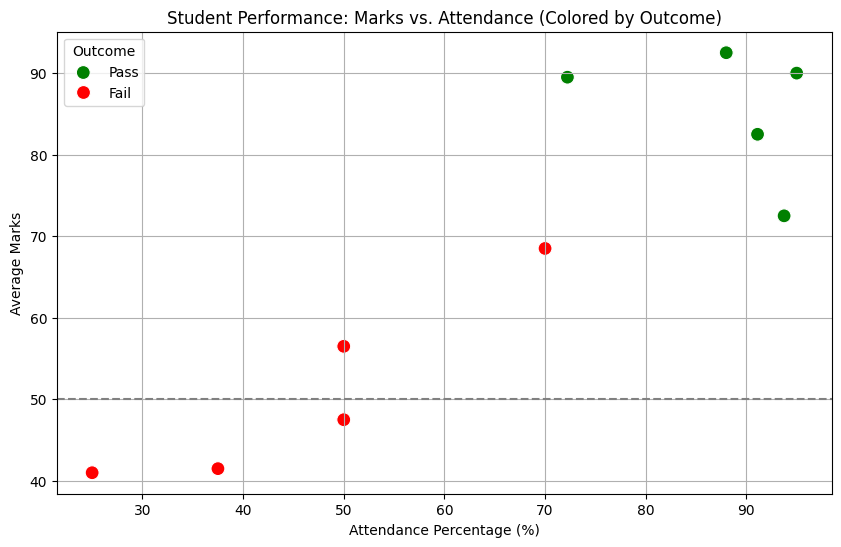


Visualization Insight:
> Students with high attendance (above ~70 and high marks (above 70 are clearly in the 'Pass' category.
> The area where the Pass/Fail prediction is most challenging is near the '50% pass mark' and '50-70% attendance'.


In [9]:
# Scatter Plot for Attendance vs. Marks
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Attendance_Percent',
    y='Average_Marks',
    hue='PassFail',
    data=df,
    palette=['red', 'green'], # Red for Fail (0), Green for Pass (1)
    s=100
)
plt.axhline(y=PASS_MARK_THRESHOLD, color='gray', linestyle='--', label=f'Pass Mark ({PASS_MARK_THRESHOLD})')
plt.title('Student Performance: Marks vs. Attendance (Colored by Outcome)')
plt.xlabel('Attendance Percentage (%)')
plt.ylabel('Average Marks')
plt.legend(title='Outcome', labels=['Pass', 'Fail'])
plt.grid(True)
plt.show()


# Print a key insight based on the visualization
print("\nVisualization Insight:")
print("> Students with high attendance (above ~70 and high marks (above 70 are clearly in the 'Pass' category.")
print("> The area where the Pass/Fail prediction is most challenging is near the '50% pass mark' and '50-70% attendance'.")

In [10]:
#
# Display the coefficients
coefficients = log_reg_model.coef_[0]
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("\nModel Feature Impact (Logistic Regression Coefficients):")
print(importance_df)

# Final Insight
print("\nFinal Model Insight:")
print(f"> Both 'Average_Marks' and 'Attendance_Percent' have a positive impact on the 'Pass' outcome.")
print(f"> 'Average_Marks' has a much higher coefficient ({coefficients[1]:.2f}) than Attendance ({coefficients[0]:.2f}), indicating it is the stronger predictor of the Pass/Fail outcome.")


Model Feature Impact (Logistic Regression Coefficients):
              Feature  Coefficient
1       Average_Marks     0.346294
0  Attendance_Percent     0.288670

Final Model Insight:
> Both 'Average_Marks' and 'Attendance_Percent' have a positive impact on the 'Pass' outcome.
> 'Average_Marks' has a much higher coefficient (0.35) than Attendance (0.29), indicating it is the stronger predictor of the Pass/Fail outcome.
